In [86]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import trapz

Generate Data ⬇️

In [87]:
def getbJetTrack(mu = 0, sig = 0.5, decay=3, fracDecay=0.05, fracFlat=0.05):
    r = np.random.rand()
    if (r < fracDecay):
        return np.random.exponential(decay)+np.random.normal(0,0.25)
    elif (r < (fracDecay+fracFlat)):
        return 6 * np.random.random_sample()-3 #get flat -3 to 2
    else:
        return np.random.normal(mu,sig) 

def getLFTrack(mu = 0, sig = 0.5, fracFlat=0.05):
    r = np.random.rand()
    if( r < fracFlat):
        return 6 * np.random.random_sample()-3
    else:        
        return np.random.normal(mu,sig)

def getbJetData(NumData, fracDecay=0.05): #get list of NumData number of elements. 
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(4)
        tracks=[]
        for j in range (n):
            tracks.append(getbJetTrack(fracDecay=fracDecay))
        DataSet.append(tracks)
    return DataSet

def getLFJetData(NumData): # get list of NumData number of elements
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(2)
        tracks=[]
        for j in range (n):
            tracks.append(getLFTrack())
        DataSet.append(tracks)
    return DataSet

KNN ⬇️

In [88]:
def DataSameLen(listOfLists): # add 0 to the end of stort list elements
    maxLen=0
    for i in listOfLists:
        if len(i)>maxLen:
            maxLen=len(i)
    for i in listOfLists:
        if len(i)<maxLen:
            while(len(i)<maxLen):
                i.append(0)
    return listOfLists

def getData(NumData): #combines B jet data and LF jet data, NumData: number of data in each, adds indicator at the front
    bj=getbJetData(NumData) #only train uses this
    j=0
    for i in bj:
        bj[j] = [True] + i
        j+=1
    lfj=getLFJetData(NumData)
    k=0
    for i in lfj:
        lfj[k] = [False] + i
        k+=1
    for j in lfj:
        bj.append(j)
    return bj

def dist(elem_train, elem_test): 
    d=0.0
    for i in range(1, len(elem_train)):
        d+=(elem_train[i]-elem_test[i-1])**2
    return np.sqrt(d)

def getNbors(train, elem_test, k):
    distance=[]
    for elem in train:
        distance.append([elem,dist(elem,elem_test)])
    distance.sort(key = lambda ls : ls[1])
    nbors=[]
    for i in range(k):
        nbors.append(distance[i][0])
    return nbors

def BjetProb(train, elem_test, k):
    neigbors=getNbors(train,elem_test,k)
    numTrue=0
    for i in neigbors:
        if (i[0]==True):
            numTrue+=1
    return float(numTrue)/float(len(neigbors))

# Plot the Data

In [89]:
def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat

In [90]:
nEvents = 50000

bj=getbJetData(nEvents, fracDecay=0.2) #only train uses this
bjFlat = flatten(bj)

lf=getLFJetData(nEvents)
lfFlat = flatten(lf)

print(f"{len(bjFlat)} vs {len(lfFlat)}")

200069 vs 100351


[-3.         -2.93939394 -2.87878788 -2.81818182 -2.75757576 -2.6969697
 -2.63636364 -2.57575758 -2.51515152 -2.45454545 -2.39393939 -2.33333333
 -2.27272727 -2.21212121 -2.15151515 -2.09090909 -2.03030303 -1.96969697
 -1.90909091 -1.84848485 -1.78787879 -1.72727273 -1.66666667 -1.60606061
 -1.54545455 -1.48484848 -1.42424242 -1.36363636 -1.3030303  -1.24242424
 -1.18181818 -1.12121212 -1.06060606 -1.         -0.93939394 -0.87878788
 -0.81818182 -0.75757576 -0.6969697  -0.63636364 -0.57575758 -0.51515152
 -0.45454545 -0.39393939 -0.33333333 -0.27272727 -0.21212121 -0.15151515
 -0.09090909 -0.03030303  0.03030303  0.09090909  0.15151515  0.21212121
  0.27272727  0.33333333  0.39393939  0.45454545  0.51515152  0.57575758
  0.63636364  0.6969697   0.75757576  0.81818182  0.87878788  0.93939394
  1.          1.06060606  1.12121212  1.18181818  1.24242424  1.3030303
  1.36363636  1.42424242  1.48484848  1.54545455  1.60606061  1.66666667
  1.72727273  1.78787879  1.84848485  1.90909091  1.9

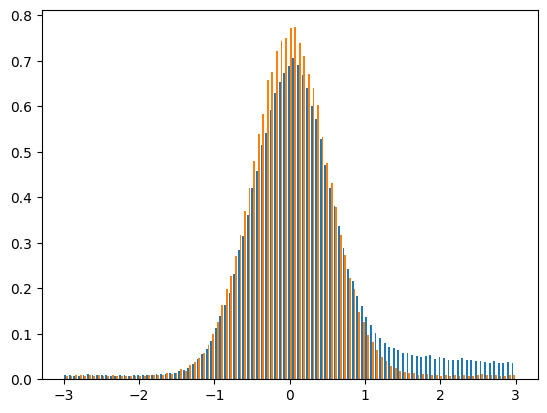

In [91]:
bins = np.linspace(-3,3,100)
#c1, b1, p1 = plt.hist(bjFlat,bins=bins,density=True)
#c2, b2, p2 = plt.hist(lfFlat,bins=bins,histtype="step", density=True)
TrainHistCounts, TrainHistBins, patch = plt.hist([bjFlat,lfFlat],bins=bins,density=True)
#plt.yscale("log")
print(TrainHistBins)
plt.show()

plot ROC

In [92]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [93]:
#getting data
n=1000
train = getData(n)
bj_test=getbJetData(n,fracDecay=0.2)
lf_test=getLFJetData(n)

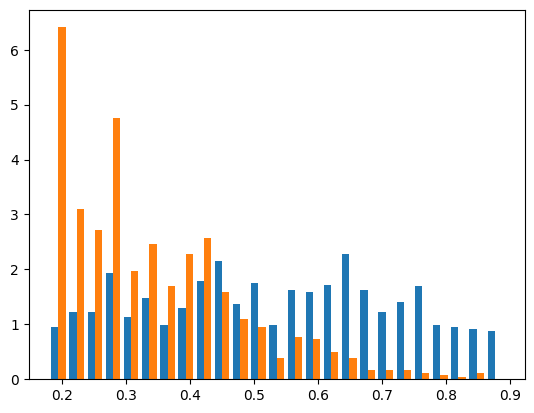

In [94]:
#KNN
train1=copy.deepcopy(train)
DataSameLen(train1)
bj_test1 = copy.deepcopy(bj_test)
DataSameLen(bj_test1)
lf_test1 = copy.deepcopy(lf_test)
DataSameLen(lf_test1)

if (len(bj_test1[0])<len(train1[0])-1):
    for i in bj_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)
if (len(lf_test1[0])<len(train1[0])-1):
    for i in lf_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)

b_prob=[]
lf_prob=[]
for i in bj_test1:
    b_prob.append(BjetProb(train1,i,100))
for i in lf_test1:
    lf_prob.append(BjetProb(train1,i,100))
counts, bins, patches= plt.hist([b_prob,lf_prob], bins=25, density=True)

In [95]:
def trim(floatListList, N):
    res=[]
    falseNum=0
    for i in floatListList:
        if len(i)<N:
            floatListList.remove(i)
            falseNum=falseNum+1
        else:
            mx=[]
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res, falseNum  

def trimTrain(floatListList, N):
    res=[]
    for i in floatListList:
        ind = i[0]
        i.pop(0)
        if len(i)<N:
            floatListList.remove(i)
        else:
            mx=[]
            mx.append(ind)
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res       

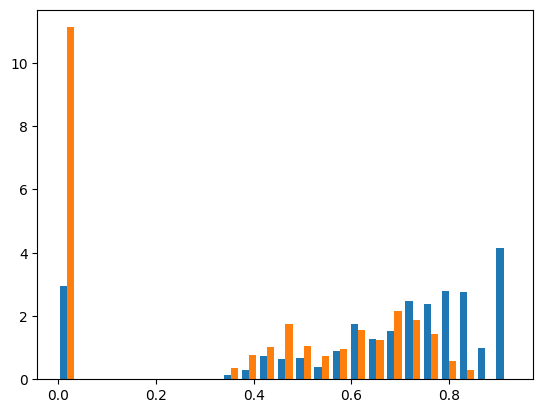

In [96]:
#2d-KNN
train2=copy.deepcopy(train)
train2=trimTrain(train2,2)

bj_test2=copy.deepcopy(bj_test)
lf_test2=copy.deepcopy(lf_test)
bj_test2, bj_fn = trim(bj_test2,2)
lf_test2, lf_fn = trim(lf_test2,2)

b_prob2=[]
lf_prob2=[]
for i in bj_test2:
    b_prob2.append(BjetProb(train2,i,100))
for i in range(bj_fn):
    b_prob2.append(0)
for i in lf_test2:
    lf_prob2.append(BjetProb(train2,i,100))
for i in range(lf_fn):
    lf_prob2.append(0)
counts2, bins2, patches2 = plt.hist([b_prob2,lf_prob2], bins=25, density=True)

[0.         0.16326531 0.32653061 0.48979592 0.65306122 0.81632653
 0.97959184 1.14285714 1.30612245 1.46938776 1.63265306 1.79591837
 1.95918367 2.12244898 2.28571429 2.44897959 2.6122449  2.7755102
 2.93877551 3.10204082 3.26530612 3.42857143 3.59183673 3.75510204
 3.91836735 4.08163265 4.24489796 4.40816327 4.57142857 4.73469388
 4.89795918 5.06122449 5.2244898  5.3877551  5.55102041 5.71428571
 5.87755102 6.04081633 6.20408163 6.36734694 6.53061224 6.69387755
 6.85714286 7.02040816 7.18367347 7.34693878 7.51020408 7.67346939
 7.83673469 8.        ]


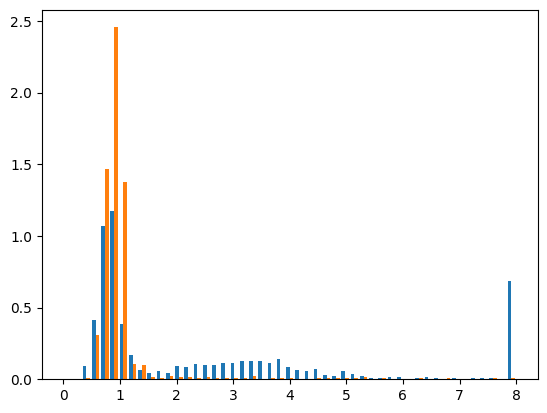

In [136]:
#likelyhood #This uses the histogram for d0
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)):  #linear search :(
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

bj_test3=copy.deepcopy(bj_test)
lf_test3=copy.deepcopy(lf_test)

bj_p3=likelihood(bj_test3,TrainHistCounts,TrainHistBins)
lf_p3=likelihood(lf_test3,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p3)):
    if bj_p3[i] > 8:
        bj_p3[i] = 8

for i in range(len(lf_p3)):
    if lf_p3[i] > 8:
        lf_p3[i] = 8

counts3, bins3, patches3 = plt.hist([bj_p3,lf_p3], bins=np.linspace(0,8,50), density=True)
print(bins3)

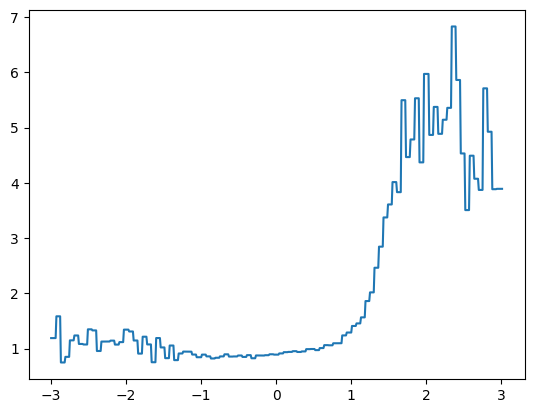

In [137]:
j=-3
list=[]
list.append(j)
while j<=3:
    j+=0.01
    list.append(j)

list2=[]
for d0 in list:
    k=probInHist(d0,TrainHistCounts,TrainHistBins)
    list2.append(k)

plt.plot(list,list2)

In [138]:
n=0  #this is for debugging, THERE ARE EMPTY LISTS
for i in bj_test3:
    if len(i)==0:
        n+=1
print(n)

18


(array([ 14.,   7.,  24., 225., 695., 758., 224.,  22.,  12.,  16.]),
 array([-2.97181777e+00, -2.37749863e+00, -1.78317950e+00, -1.18886037e+00,
        -5.94541236e-01, -2.22104026e-04,  5.94097028e-01,  1.18841616e+00,
         1.78273529e+00,  2.37705443e+00,  2.97137356e+00]),
 <BarContainer object of 10 artists>)

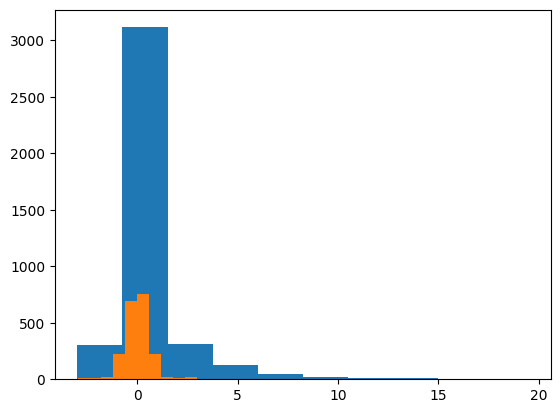

In [139]:
plt.hist(flatten(bj_test3))
plt.hist(flatten(lf_test3))

[[0.       0.       0.091875 0.410375 1.071875 1.176    0.385875 0.1715
  0.067375 0.042875 0.055125 0.042875 0.091875 0.08575  0.104125 0.098
  0.098    0.11025  0.116375 0.128625 0.128625 0.128625 0.116375 0.140875
  0.08575  0.067375 0.055125 0.0735   0.030625 0.0245   0.055125 0.03675
  0.0245   0.006125 0.01225  0.018375 0.018375 0.       0.01225  0.018375
  0.006125 0.       0.01225  0.       0.006125 0.006125 0.006125 0.
  0.686   ]
 [0.       0.       0.01225  0.30625  1.47     2.456125 1.378125 0.104125
  0.098    0.018375 0.01225  0.0245   0.018375 0.018375 0.006125 0.018375
  0.006125 0.006125 0.01225  0.006125 0.0245   0.       0.01225  0.01225
  0.006125 0.       0.       0.006125 0.01225  0.01225  0.006125 0.006125
  0.018375 0.       0.01225  0.       0.       0.       0.006125 0.
  0.       0.006125 0.       0.       0.       0.       0.006125 0.
  0.006125]]


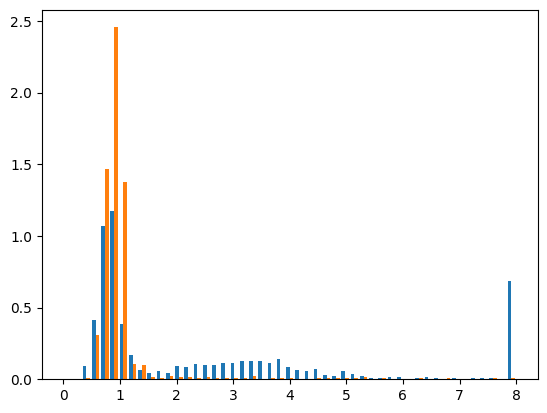

In [140]:
#POISSSON likelyhood
def Poissonlikelyhood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=len(i)
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

bj_test4=copy.deepcopy(bj_test) 
lf_test4=copy.deepcopy(lf_test)

bj_p4=likelihood(bj_test4,TrainHistCounts,TrainHistBins)
lf_p4=likelihood(lf_test4,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p4)):
    if bj_p4[i] > 8:
        bj_p4[i] = 8

for i in range(len(lf_p4)):
    if lf_p4[i] > 8:
        lf_p4[i] = 8
        
counts4, bins4, patches4 = plt.hist([bj_p4,lf_p4], bins=np.linspace(0,8,50), density=True)

print(counts4)

AUC of knn: 0.7856890000000005
AUC of 2d knn: 0.7858405914332474
AUC of likelyhood: 0.6543975000000003
0.6543975000000003


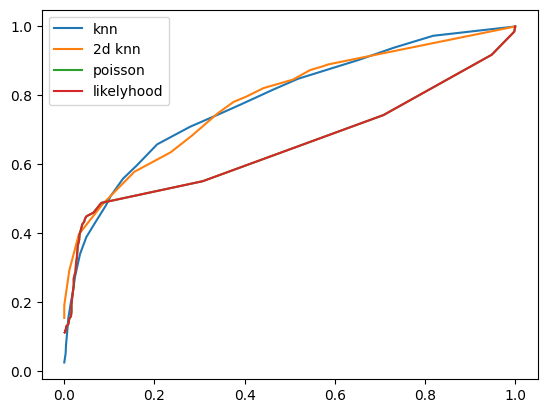

In [147]:
area1 = pltROCnAUC(counts, bins, "knn")
area2 = pltROCnAUC(counts2, bins2, "2d knn")
area3 = pltROCnAUC(counts3, bins3, "likelyhood")
area4 = pltROCnAUC(counts4, bins4, "poisson")

print("AUC of knn:",-area1)
print("AUC of 2d knn:",-area2)
print("AUC of likelyhood:",-area3)
print(-area4)